<a href="https://colab.research.google.com/github/JakobSchauser/BachelorProject-IceCube-ML/blob/main/Third_working_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install spektral -q

     |████████████████████████████████| 122kB 6.1MB/s 


In [2]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import MeanAbsoluteError as MeanAbsoluteError_acc
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from spektral.data import DisjointLoader, Dataset
from spektral.datasets import QM9
from spektral.layers import ECCConv, GlobalSumPool, GCNConv

from tqdm.notebook import tqdm

PI = np.pi

# Lifehack
true = True
false = False

In [159]:
################################################################################
# LOAD DATA
################################################################################

class dat(Dataset):
  def __init__(self,n = 1,**kwargs):
    self.n = n
    super().__init__(**kwargs)
  def read(self):
    # path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/generatedDataAnglesEnergy100000 0.npz" # Uncleaned
    path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/generatedDataAnglesEnergyClean200000events 0.npz" # Cleaned
    # path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/data.dat" # From Severin
    dataset = np.load(path,allow_pickle = True)["arr_0"]
    graphs = []
    for g in dataset:
      graphs.append(g)
    return np.array(dataset)

dataset = dat()

print("Dataset is", dataset, "consisting of", dataset[0])



#### Put on GPU when possible
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("Running on GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("Running on CPU")

Dataset is dat(n_graphs=200000) consisting of Graph(n_nodes=13, n_node_features=5, n_edge_features=None, n_labels=3)
Running on CPU


In [181]:
alls = np.zeros((100000,3))
for k in range(100000):
  alls[k] = dataset[k]["y"]

print(np.max(alls,axis=0))
print(np.min(alls,axis=0))

[1.65156444 0.97610687 0.43305356]
[-0.56945495 -0.99504761 -0.88597444]


In [182]:
################################################################################
# PARAMETERS
################################################################################
learning_rate = 1e-4  # Learning rate
epochs = 200  # Number of training epochs
test_epochs = 2 # Number of testing epochs
batch_size = 64  # Batch size

network_size = 64 # one-variable network size changer


# Parameters
F = dataset.n_node_features  # Dimension of node features
S = dataset.n_edge_features  # Dimension of edge features
n_out = dataset.n_labels  # Dimension of the target

# Train/test split
idxs = np.random.permutation(len(dataset))
split = int(0.9 * len(dataset))
idx_tr, idx_te = np.split(idxs, [split])
dataset_tr, dataset_te = dataset[idx_tr], dataset[idx_te]

train_loader = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs)
test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=test_epochs, shuffle=True)

In [183]:
################################################################################
# BUILD MODEL
################################################################################
X_in = Input(shape=(F,), name="X_in")
A_in = Input(shape=(None,), sparse=True, name="A_in")
# E_in = Input(shape=(S,), name="E_in")
I_in = Input(shape=(), name="segment_ids_in", dtype=tf.int32)

x = GCNConv(network_size, activation="relu")([X_in, A_in])
x = GCNConv(network_size*3//4, activation="relu")([x, A_in])
# x = GCNConv(network_size*3//4, activation="relu")([x, A_in])
x = GCNConv(network_size*3//4, activation="relu")([x, A_in])
x = GCNConv(network_size, activation="relu")([x, A_in])

X_out = GlobalSumPool()([x, I_in])
output = Dense(n_out)(X_out)

# Build model
model = Model(inputs=[X_in, A_in, I_in], outputs=output)
opt = Adam(lr=learning_rate)
loss_fn = MeanSquaredError()
# loss_fn = MeanAbsoluteError()
acc_fn = MeanAbsoluteError()
model.compile()
model.summary()
print("Model input shape:",model.input_shape)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_in (InputLayer)               [(None, 5)]          0                                            
__________________________________________________________________________________________________
A_in (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
gcn_conv_12 (GCNConv)           (None, 64)           320         X_in[0][0]                       
                                                                 A_in[0][0]                       
__________________________________________________________________________________________________
gcn_conv_13 (GCNConv)           (None, 48)           3072        gcn_conv_12[0][0]          

In [184]:
################################################################################
# FIT MODEL
################################################################################
@tf.function(input_signature=train_loader.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions)
        loss += sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    acc = acc_fn(target,predictions)

    return loss, acc

def validate(inputs,target):
    predictions = model(inputs, training=False)
    loss = loss_fn(target, predictions)
    loss += sum(model.losses)
    acc = acc_fn(target,predictions)

    return loss, acc

def scale_inputs(inputs):
    inputs[0][:,:3] = inputs[0][:,:3]/100 # x y z
    inputs[0][:,3] = inputs[0][:,3]/10000 # time
    inputs[0][:,4] = inputs[0][:,4]/1 # charge
    return inputs

def custom_loss(target,predictions):
    predictions = tf.cast(predictions,"float64")

    energy = tf.abs(target[:,0] - predictions[:,0])# tf.square(target[:,0] - predictions[:,0])
    azi, zeni = target[:,1] - predictions[:,1], target[:,2] - predictions[:,2]
    azi  = tf.minimum(tf.abs(azi ), tf.abs(tf.abs(azi )-2))     # 1 should be pi or 2pi
    zeni = tf.minimum(tf.abs(zeni), tf.abs(tf.abs(zeni)-2))  # 1 should be pi or 2pi

    loss = 0
    loss += tf.reduce_mean(tf.square(energy))
    loss += tf.reduce_mean(tf.square(azi))
    loss += tf.reduce_mean(tf.square(zeni))
    return loss


loss_fn = custom_loss

print("Fitting model")

current_batch = 0
model_loss = []
model_acc = []
vali_acc = []
epoch = 0

epoch_steps = train_loader.steps_per_epoch


t = tqdm(train_loader,total  = train_loader.steps_per_epoch*train_loader.epochs,leave = True)
t.set_description(f'Currently on epoch {0} of {epochs} ')

pb = []
tar = []
step = 0

last_vali = 0

if False:
  for batch in t:
      step += 1
      inputs, target = batch
      inputs = scale_inputs(inputs)

      loss, acc = train_step(inputs,target)

      model_loss.append(loss)
      model_acc.append(acc)
      current_batch += 1
      if current_batch == epoch_steps:
          test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=test_epochs, shuffle=True)
          t.set_description(f'Currently validating results')

          for vali_batch in test_loader:
            vali_inputs, vali_target = vali_batch
            valie_inputs = scale_inputs(vali_inputs)
            vali_loss, va = validate(vali_inputs,vali_target)
            vali_acc.append(vali_loss)
          va = np.mean(vali_acc)
          change = (va-last_vali)/max(0.000001,last_vali)
          last_vali = va
          s = "Train loss: {} - Train accuracy: {} | Validation loss {} - Change {:.3}% | Epoch: {}".format(np.mean(model_loss), np.mean(model_acc), va, change*100, epoch)
          t.write(s)
          if epoch%5 == 0 and epoch != 0:
            print("Two current guesses are\n",np.array(pb[0]),np.array(pb[1]),"for\n",target[0],target[1])
          else:
            pb = model(inputs, training=False)

          model_loss = []
          model_acc = []
          vali_acc = []
          current_batch = 0
          step = 0

          epoch += 1
          t.set_description(f'Currently on epoch {epoch} of {epochs} ')



Fitting model


In [ ]:
model.save("2e5SavedModel-AnglesEnergy-100epochs")

dataset_targets = ["energy_log10","azimuth","zenith"]
# dataset targets = ["energy_log10", "position_x", "position_y", "position_z", "direction_x", "direction_y", "direction_z"]

INFO:tensorflow:Assets written to: 2e5SavedModel-AnglesEnergy-100epochs/assets


In [185]:
model = keras.models.load_model("/content/drive/MyDrive/Bachelor Project - IceCube ML/2e5SavedModel-AnglesEnergy-100epochs")
model.build(input_shape = [(None, 5), (None, None), (None,)])
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_in (InputLayer)               [(None, 5)]          0                                            
__________________________________________________________________________________________________
A_in (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
gcn_conv_41 (GCNConv)           (None, 64)           320         X_in[0][0]                       
                                                                 A_in[0][0]                       
__________________________________________________________________________________________________
gcn_conv_42 (GCNConv)           (None, 48)           3072        gcn_conv_41[0][0]          

In [197]:
################################################################################
# EVALUATE MODEL
################################################################################
print("Testing model")
model_loss = 0
model_acc = 0
steps = 0
test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=1,shuffle = True)

predictions, truths = [],[]

@tf.function(input_signature=test_loader.tf_signature(), experimental_relax_shapes=True)
def get_preds(inputs,target):
  return model(inputs,training = False)


for i, batch in enumerate(test_loader):
  steps += 1
  inputs, target = batch
  inputs = scale_inputs(inputs)
  # print(inputs)
  pred = get_preds(inputs,target)

  predictions.append(np.array(pred))
  truths.append(np.array(target))

  model_loss += loss_fn(target, pred)
  model_acc += acc_fn(target, pred)


predictions = np.array(predictions)
truths = np.array(truths)

def make1D(a):
  new = []
  for aa in a:
    for aaa in aa:
      new.append(aaa)
  return np.array(new)

predictions = make1D(predictions)
truths = make1D(truths)




print("Done! \nTest loss: {}\nTest Acc: {}".format(model_loss/steps, model_acc/steps))


Testing model
Done! 
Test loss: 0.8482987179381244
Test Acc: 0.350358247756958


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [200]:
diffs = abs(truths-predictions)
periodic = abs(abs(truths-predictions)-2)
diffs = np.minimum(diffs,periodic)

d_energy, d_zenith, d_azimuth = diffs[:,0], diffs[:,1], diffs[:,2]
energies = truths[:,0]
d_zenith

array([0.42242751, 0.62551973, 0.80587194, ..., 0.06442789, 0.20733558,
       0.08234703])

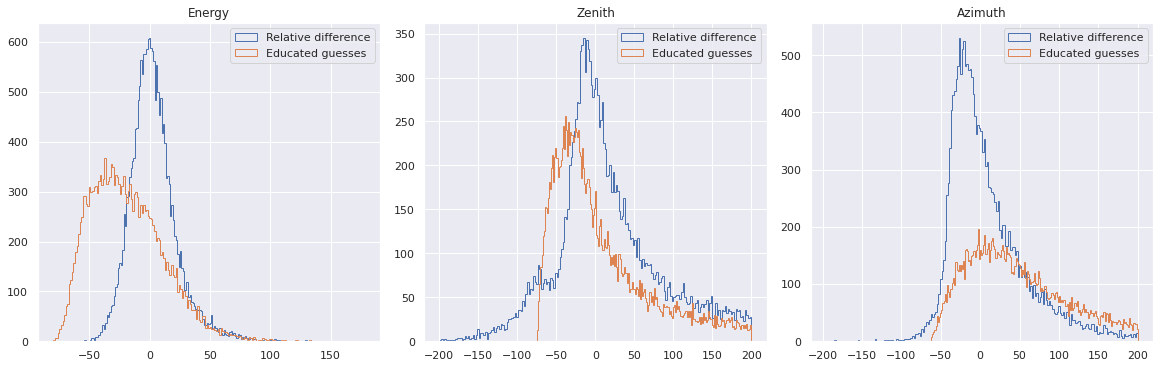

In [227]:
fig, axs = plt.subplots(1,3,figsize=(16,5),constrained_layout=True)

titles = ["Energy","Zenith","Azimuth"]



random = np.random.random(truths.shape)-0.5

for i in range(3):
  perc = (predictions[:,i]-truths[:,i])/(truths[:,i]+1)*100
  rnd = (random[:,i]-truths[:,i])/(truths[:,i]+1)*100
  axs[i].hist(perc[np.where(abs(perc)<200)],bins=200,histtype="step",label="Relative difference")
  axs[i].hist(rnd[np.where(abs(rnd)<200)],bins=200,histtype="step",label = "Educated guesses")
  axs[i].legend()
  axs[i].set_title(titles[i])


plt.show()

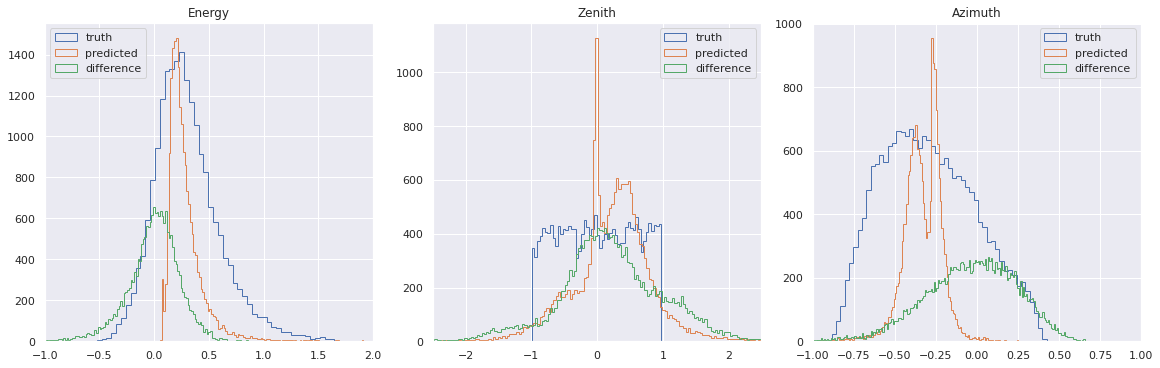

In [216]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
fig, axs = plt.subplots(1,3,figsize=(16,5),constrained_layout=True)


for i in range(3):
  axs[i].hist(truths[:,i],bins = 50,histtype = "step",label="truth")
  axs[i].hist(predictions[:,i],bins = 500,histtype = "step",label="predicted")
  axs[i].hist((predictions[:,i]-truths[:,i]),bins = 500,histtype = "step",label="difference")

  axs[i].legend()

axs[0].set(xlim=(-1,2),title= "Energy")
axs[1].set(xlim=(-2.5,2.5),title= "Zenith")
axs[2].set(xlim=(-1,1),title= "Azimuth")


# plt.plot(energies,predictions[:,1]-truths[:,1],'.',label = "predictions",markersize=2)
# plt.plot(energies,truths[:,1],'.',label="truth",markersize=2)
# plt.legend()
plt.show()

In [132]:
print(predictions.shape,truths.shape)

(20000, 3) (20000, 3)
